In [1]:
import pandas as pd
import numpy as np
import os
import json
from scipy.stats import fisher_exact

# Load data

In [2]:
import pickle
infile = open("interaction_data.pkl",'rb')
d = pickle.load(infile)
infile.close()

infile = open("phase3_selections.pkl",'rb')
selected_item_interactions = pickle.load(infile)
infile.close()

infile = open("df_completed_participation.pkl",'rb')
df_completed_participation = pickle.load(infile)
infile.close()

# High-level feedback: relative comparison

In [3]:
df = d.copy()

In [4]:
relative_comparison_data = df[df.data.str.contains("radio-sub-component")]
relative_comparison_data["relative_comparison"] = 0

relative_comparison_data["relative_comparison"] = relative_comparison_data.data.map(lambda x: json.loads(x).get("value", 0))
dct = {"first":-2, "second":-1,"third":0,"fourth":1,"fifth":2}
relative_comparison_data["relative_comparison_numeric"] = relative_comparison_data["relative_comparison"].map(lambda x: dct[x])


<ipython-input-4-4084f8a5de2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relative_comparison_data["relative_comparison"] = 0
<ipython-input-4-4084f8a5de2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relative_comparison_data["relative_comparison"] = relative_comparison_data.data.map(lambda x: json.loads(x).get("value", 0))
<ipython-input-4-4084f8a5de2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [5]:
relative_comparison_data = relative_comparison_data.sort_values(["participation","iteration","time"])
relative_comparison_data = relative_comparison_data.drop_duplicates(["participation","iteration","variant"],keep="last")
relative_comparison_data.shape

(1063, 12)

In [6]:
rcgb = relative_comparison_data.groupby("relative_comparison_numeric").count()[["relative_comparison"]]
rcgb

,relative_comparison
relative_comparison_numeric,
-2,121
-1,261
0,316
1,259
2,106


In [7]:
contingency_table_ind = pd.crosstab(relative_comparison_data.result_layout,relative_comparison_data.relative_comparison_numeric)
contingency_table_ind

relative_comparison_numeric,-2,-1,0,1,2
result_layout,,,,,
column-single,23,56,55,47,17
columns,21,48,50,51,13
max-columns,22,30,52,40,28
row-single,19,40,65,33,16
row-single-scrollable,18,32,49,43,15
rows,18,55,45,45,17


In [8]:
contingency_table = pd.crosstab(relative_comparison_data.layout_high_level,relative_comparison_data.relative_comparison_numeric)
contingency_table

relative_comparison_numeric,-2,-1,0,1,2
layout_high_level,,,,,
cols,66,134,157,138,58
rows,55,127,159,121,48


In [9]:
from scipy.stats import binom_test, fisher_exact
succ = contingency_table.loc["rows",-2]+contingency_table.loc["rows",-1]
fail = contingency_table.loc["rows",1]+contingency_table.loc["rows",2]
print(binom_test(succ, succ+fail,p=0.5,alternative='greater'))


0.2609490440937195


In [10]:
from scipy.stats import binom_test, fisher_exact
rcgb = relative_comparison_data.groupby("relative_comparison_numeric").count()[["relative_comparison"]]
succ = rcgb.loc[-2,"relative_comparison"]+rcgb.loc[-1,"relative_comparison"]
fail = rcgb.loc[1,"relative_comparison"]+rcgb.loc[2,"relative_comparison"]
print(binom_test(succ, succ+fail,p=0.5,alternative='greater'))

0.27915071070263264


- For relative comparison, advantaged algorithm received slightly higher preferences - but not stat. sign even while not distingushing among individual layouts

In [11]:
relative_comp_no_eq = relative_comparison_data.loc[relative_comparison_data.relative_comparison_numeric != 0]
relative_comp_no_eq["winning"] = "first"
relative_comp_no_eq.loc[relative_comp_no_eq.relative_comparison_numeric > 0, "winning"] = "second"

contingency_table = pd.crosstab(relative_comp_no_eq.layout_high_level,relative_comp_no_eq.winning)
contingency_table

<ipython-input-11-1178ec4d733f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relative_comp_no_eq["winning"] = "first"
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


winning,first,second
layout_high_level,,
cols,200,196
rows,182,169


In [12]:
from scipy.stats import fisher_exact
fisher_exact(contingency_table)

(0.9475218658892128, 0.714631698077167)

- seemingly, no difference here

In [13]:
relative_comparison_data.groupby(["result_layout"])[["relative_comparison_numeric"]].mean().round(3)

,relative_comparison_numeric
result_layout,
column-single,-0.106
columns,-0.071
max-columns,0.128
row-single,-0.075
row-single-scrollable,0.032
rows,-0.067


- not much difference here either

# High-level feedback: rating algorithms

In [14]:
rating_data = df[df.data.str.contains('"input_type": "rating"')]
rating_data["variant"] = rating_data.data.map(lambda x: json.loads(x).get("variant", -1))
rating_data["rating"] = rating_data.data.map(lambda x: json.loads(x).get("new_rating", -1))
rating_data = rating_data.sort_values(["participation","iteration","variant","time"])
rating_data = rating_data.drop_duplicates(["participation","iteration","variant"],keep="last")
rating_data

<ipython-input-14-a65bcddd8f81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data["variant"] = rating_data.data.map(lambda x: json.loads(x).get("variant", -1))
<ipython-input-14-a65bcddd8f81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data["rating"] = rating_data.data.map(lambda x: json.loads(x).get("new_rating", -1))


,participation,interaction_type,time,data,iteration,result_layout,GAMMA,DELTA,variant,layout_high_level,rating
id,,,,,,,,,,,
3287,36,on-input,2023-01-15 23:16:21.116547,"{""variant"": 0, ""variant_name"": ""DELTA"", ""old_r...",1.0,row-single-scrollable,1.0,0.0,0,rows,4
3288,36,on-input,2023-01-15 23:16:22.800032,"{""variant"": 1, ""variant_name"": ""GAMMA"", ""old_r...",1.0,row-single-scrollable,1.0,0.0,1,rows,4
3307,36,on-input,2023-01-15 23:16:50.703590,"{""variant"": 0, ""variant_name"": ""GAMMA"", ""old_r...",2.0,columns,0.0,1.0,0,cols,4
3306,36,on-input,2023-01-15 23:16:49.672394,"{""variant"": 1, ""variant_name"": ""DELTA"", ""old_r...",2.0,columns,0.0,1.0,1,cols,4
3316,36,on-input,2023-01-15 23:17:18.883702,"{""variant"": 0, ""variant_name"": ""GAMMA"", ""old_r...",3.0,max-columns,0.0,1.0,0,cols,2
...,...,...,...,...,...,...,...,...,...,...,...
47742,261,on-input,2023-02-05 18:45:48.779783,"{""variant"": 1, ""variant_name"": ""DELTA"", ""old_r...",6.0,row-single-scrollable,0.0,1.0,1,rows,4
47761,261,on-input,2023-02-05 18:46:24.734999,"{""variant"": 0, ""variant_name"": ""GAMMA"", ""old_r...",7.0,columns,0.0,1.0,0,cols,1
47773,261,on-input,2023-02-05 18:46:45.523096,"{""variant"": 1, ""variant_name"": ""DELTA"", ""old_r...",7.0,columns,0.0,1.0,1,cols,3


In [15]:
rating_data.groupby("variant")[["rating"]].mean()

,rating
variant,
0,3.123480
1,3.081384


In [16]:
from scipy.stats import ttest_ind, ttest_rel
dx = rating_data.loc[((rating_data.variant==0) & (rating_data.result_layout=="rows"))]
dy = rating_data.loc[((rating_data.variant==1) & (rating_data.result_layout=="rows"))]
dx = dx.set_index(["participation","iteration"])
dy = dy.set_index(["participation","iteration"])
dRes = dx.join(dy, how="inner", rsuffix = "_1")
ttest_rel(dRes["rating"],dRes["rating_1"])

Ttest_relResult(statistic=0.9515673319215723, pvalue=0.34259955939177045)

- not significant enough

In [17]:
rating_data.groupby(["result_layout","variant"])[["rating"]].mean().round(2)

rating
result_layout         variant        
column-single         0          3.06
                      1          2.99
columns               0          3.14
                      1          3.04
max-columns           0          3.12
                      1          3.14
row-single            0          3.06
                      1          3.07
row-single-scrollable 0          3.12
                      1          3.11
rows                  0          3.24
                      1          3.14

In [18]:
rating_data.groupby(["layout_high_level","variant"])[["rating"]].mean()

rating
layout_high_level variant          
cols              0        3.105735
                  1        3.055556
rows              0        3.142857
                  1        3.109589

In [19]:
dx = rating_data.loc[rating_data.result_layout=="rows","rating"]
dy = rating_data.loc[rating_data.result_layout=="row-single-scrollable","rating"]
ttest_ind(dx,dy)

Ttest_indResult(statistic=0.8032994394995778, pvalue=0.422084454468898)

In [20]:
dx = rating_data.loc[rating_data.result_layout=="rows","rating"]
dy = rating_data.loc[rating_data.result_layout!="rows","rating"]
ttest_ind(dx,dy)

Ttest_indResult(statistic=1.5811426599496048, pvalue=0.11399347602174799)

In [21]:
dx = rating_data.loc[rating_data.result_layout=="rows"].loc[rating_data.variant==0, "rating"]
dy = rating_data.loc[rating_data.result_layout=="rows"].loc[rating_data.variant==1, "rating"]
ttest_rel(dx,dy)

Ttest_relResult(statistic=0.9515673319215723, pvalue=0.34259955939177045)

In [22]:
dx = rating_data.loc[rating_data.result_layout=="columns"].loc[rating_data.variant==0, "rating"]
dy = rating_data.loc[rating_data.result_layout=="columns"].loc[rating_data.variant==1, "rating"]
ttest_rel(dx,dy)

Ttest_relResult(statistic=1.0916485541893324, pvalue=0.27639963088400127)

### There seems to be some minor differences between rating patterns of individual layouts, but not significant enough

# How well low-level feedback corresponds to the high-level ones

### Get statistics on items that were mutually recommended by both RS

In [23]:
def getMovieId(x):
    return x["movie_id"]

itemsDict = {"participation":[],
            "iteration":[],
            "layout_high_level":[],
            "results_layout":[],
            "order":[], 
            "algorithm":[], 
            "rank":[], 
            "movieID":[] 
            }

pageLoads = d.loc[d.interaction_type == "loaded-page"]

for idx, row in pageLoads.iterrows():
    dt = json.loads(row.data)
    page = dt["page"]
    if page == "compare_algorithms":
        deltaMovies = dt["context"]["extra"]["movies"]["delta"]["movies"]
        deltaOrder = dt["context"]["extra"]["movies"]["delta"]["order"]
        gammaMovies = dt["context"]["extra"]["movies"]["gamma"]["movies"]
        gammaOrder = dt["context"]["extra"]["movies"]["gamma"]["order"]
        
        deltaMIDs = list(map(getMovieId, deltaMovies))
        gammaMIDs = list(map(getMovieId, gammaMovies))
        
        for c, val in enumerate(deltaMIDs):
            itemsDict["participation"].append(row["participation"])
            itemsDict["iteration"].append(row["iteration"])
            itemsDict["layout_high_level"].append(row["layout_high_level"])
            itemsDict["results_layout"].append(row["result_layout"])
            itemsDict["order"].append(deltaOrder)
            itemsDict["algorithm"].append("delta")
            itemsDict["rank"].append(c)
            itemsDict["movieID"].append(val)
            
        for c, val in enumerate(gammaMIDs):
            itemsDict["participation"].append(row["participation"])
            itemsDict["iteration"].append(row["iteration"])
            itemsDict["layout_high_level"].append(row["layout_high_level"])
            itemsDict["results_layout"].append(row["result_layout"])
            itemsDict["order"].append(gammaOrder)
            itemsDict["algorithm"].append("gamma")
            itemsDict["rank"].append(c)
            itemsDict["movieID"].append(val)        


In [24]:
displayedItems = pd.DataFrame(itemsDict)

In [25]:
displayedItemsLeft = displayedItems.loc[displayedItems.order == 0]
displayedItemsLeft = displayedItemsLeft.set_index(["participation","iteration","movieID"])[["layout_high_level","results_layout","algorithm","rank"]]
displayedItemsRight = displayedItems.loc[displayedItems.order == 1]
displayedItemsRight = displayedItemsRight.set_index(["participation","iteration","movieID"])[["algorithm","rank"]]

pairedItems = displayedItemsLeft.join(displayedItemsRight, how="inner", rsuffix="_r")
pairedItems["leftRightRankComparison"] = 0
pairedItems.loc[pairedItems["rank"] < pairedItems.rank_r, "leftRightRankComparison"] = -1
pairedItems.loc[pairedItems["rank"] > pairedItems.rank_r, "leftRightRankComparison"] = 1

pairedItems["leftRightRelaxed"] = 0
pairedItems.loc[pairedItems["rank"] - pairedItems.rank_r < -1, "leftRightRelaxed"] = -1
pairedItems.loc[pairedItems["rank"] - pairedItems.rank_r > 1, "leftRightRelaxed"] = 1

pairedItems["rankDiff"] = pairedItems["rank"] - pairedItems["rank_r"] # positive values: better ranking of the right one

In [26]:
sIt = selected_item_interactions[["participation","time","iteration","variant","movieID"]]
sIt = sIt.set_index(["participation","iteration","movieID"])

In [27]:
pairedSelectedItems = pairedItems.join(sIt, how="inner", rsuffix="_selected")

In [28]:
rt1 = d.drop_duplicates(["participation","iteration"]).set_index(["participation","iteration"])[["result_layout","layout_high_level"]]
rt1["variant"] = 0
rt2 = rt1.copy()
rt2["variant"] = 1
resultTypes = pd.concat([rt1,rt2]).reset_index().set_index(["participation","iteration","variant"])
#this is due to missing data in case of no items were selected from particular variant

In [29]:
gb = selected_item_interactions.groupby(["participation","iteration","variant"])[["movieID"]].count()
gb.columns = ["selectedCount"]
gb = resultTypes.join(gb, how="outer")
gb = gb.fillna(0)
meanUser = gb.reset_index().groupby("participation")[["selectedCount"]].mean()
meanUser.columns = ["meanPerUser"]
gb = gb.join(meanUser)

pairedRes = pairedSelectedItems.reset_index()
pairedRes["variant"] = (pairedRes["variant"]+1).mod(2)
pairedRes = pairedRes.groupby(["participation","iteration","variant"])[["movieID"]].count()
pairedRes.columns=["pairedSelectedMovies"]
gb = gb.join(pairedRes, how="outer")
gb.fillna(0, inplace=True)
gb["selectedWithPaired"] = gb["selectedCount"] + gb["pairedSelectedMovies"]

meanUser = gb.reset_index().groupby("participation")[["selectedWithPaired"]].mean()
meanUser.columns = ["meanPerUserWithPaired"]
gb = gb.join(meanUser)
gb["userNormSelected"] = gb["selectedCount"] - gb["meanPerUser"]
gb["userNormSelectedWithPaired"] = gb["selectedWithPaired"] - gb["meanPerUserWithPaired"]

In [30]:
r = rating_data.set_index(["participation","iteration","variant"])[["rating"]]
gb = gb.join(r, how="inner")
gbr = gb[["selectedCount","selectedWithPaired","userNormSelected","userNormSelectedWithPaired","rating","result_layout","layout_high_level"]]

In [31]:
for i in gbr.result_layout.unique():   
    print(i)
    print(gbr.loc[gbr.result_layout==i,["selectedCount","selectedWithPaired","rating"]].corr("pearson").round(2))
    print()

row-single-scrollable
                    selectedCount  selectedWithPaired  rating
selectedCount                1.00                0.93    0.62
selectedWithPaired           0.93                1.00    0.61
rating                       0.62                0.61    1.00

columns
                    selectedCount  selectedWithPaired  rating
selectedCount                1.00                0.93    0.60
selectedWithPaired           0.93                1.00    0.62
rating                       0.60                0.62    1.00

max-columns
                    selectedCount  selectedWithPaired  rating
selectedCount                1.00                0.95    0.63
selectedWithPaired           0.95                1.00    0.65
rating                       0.63                0.65    1.00

rows
                    selectedCount  selectedWithPaired  rating
selectedCount                1.00                0.87    0.60
selectedWithPaired           0.87                1.00    0.62
rating              

In [32]:
gbr.corr().round(2)

,selectedCount,selectedWithPaired,userNormSelected,userNormSelectedWithPaired,rating
selectedCount,1.00,0.91,0.82,0.72,0.62
selectedWithPaired,0.91,1.00,0.71,0.81,0.63
userNormSelected,0.82,0.71,1.00,0.88,0.58
userNormSelectedWithPaired,0.72,0.81,0.88,1.00,0.60
rating,0.62,0.63,0.58,0.60,1.00


- there is quite strong relation between low-level feedback and high-level algorithm rating 
- but still, it is far from identity

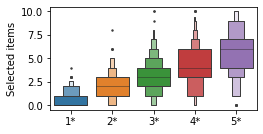

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(3.7)
f.set_figheight(1.9)

sns.boxenplot(data = [gbr.loc[gbr.rating == 1, "selectedCount"],
              gbr.loc[gbr.rating == 2, "selectedCount"],
              gbr.loc[gbr.rating == 3, "selectedCount"],
              gbr.loc[gbr.rating == 4, "selectedCount"],
              gbr.loc[gbr.rating == 5, "selectedCount"]], linewidth=1, flier_kws={"marker":"o", "s":2})
plt.ylim([-0.5, 10.5])
ax = plt.gca()
ax.set_xticklabels(["1*","2*","3*","4*","5*"])
plt.ylabel("Selected items")
plt.show()

In [34]:
rcd = relative_comparison_data.set_index(["participation","iteration"])[["relative_comparison_numeric"]]
rcd.shape

(1063, 1)

In [35]:
countSelections = gbr.reset_index(2)
v0 = countSelections.loc[countSelections.variant==0]
v1 = countSelections.loc[countSelections.variant==1]
variant_joined = v0.join(v1, how="outer", rsuffix="_v1")
variant_joined.fillna(0, inplace=True)
variant_joined["difference"] = variant_joined["selectedCount"] - variant_joined["selectedCount_v1"] 
variant_joined["differenceWithPaired"] = variant_joined["selectedWithPaired"] - variant_joined["selectedWithPaired_v1"] 
variant_joined.head()

variant  selectedCount  selectedWithPaired  \
participation iteration                                               
36            1.0            0.0            4.0                 4.0   
              2.0            0.0            5.0                 5.0   
              3.0            0.0            1.0                 1.0   
              4.0            0.0            4.0                 4.0   
              5.0            0.0            1.0                 1.0   

                         userNormSelected  userNormSelectedWithPaired  rating  \
participation iteration                                                         
36            1.0                  2.1875                      1.3125     4.0   
              2.0                  3.1875                      2.3125     4.0   
              3.0                 -0.8125                     -1.6875     2.0   
              4.0                  2.1875                      1.3125     3.0   
              5.0                 -0.8125                     -1.6875     2.0   

                                 result_layout layout_high_level  variant_v1  \
participation iteration                                                        
36            1.0        row-single-scrollable              rows         1.0   
              2.0                      columns              cols         1.0   
              3.0                  max-columns              cols         1.0   
              4.0                         rows              rows         1.0   
              5.0        row-single-scrollable              rows         1.0   

                         selectedCount_v1  selectedWithPaired_v1  \
participation iteration                                            
36            1.0                     2.0                    2.0   
              2.0                     0.0                    5.0   
              3.0                     1.0                    2.0   
              4.0                     0.0                    2.0   
              5.0                     1.0                    1.0   

                         userNormSelected_v1  userNormSelectedWithPaired_v1  \
participation iteration                                                       
36            1.0                     0.1875                        -0.6875   
              2.0                    -1.8125                         2.3125   
              3.0                    -0.8125                        -0.6875   
              4.0                    -1.8125                        -0.6875   
              5.0                    -0.8125                        -1.6875   

                         rating_v1       result_layout_v1  \
participation iteration                                     
36            1.0              4.0  row-single-scrollable   
              2.0              4.0                columns   
              3.0              3.0            max-columns   
              4.0              2.0                   rows   
              5.0              2.0  row-single-scrollable   

                        layout_high_level_v1  difference  differenceWithPaired  
participation iteration                                                         
36            1.0                       rows         2.0                   2.0  
              2.0                       cols         5.0                   0.0  
              3.0                       cols         0.0                  -1.0  
              4.0                       rows         4.0                   2.0  
              5.0                       rows         0.0                   0.0

In [36]:
rcd = rcd.join(variant_joined, how="inner")
rcd.shape

(1063, 19)

In [37]:
rcd = rcd.loc[rcd.difference >=-10].loc[rcd.difference <=10]
rcd

relative_comparison_numeric  variant  selectedCount  \
participation iteration                                                        
36            1.0                                  0      0.0            4.0   
              2.0                                  0      0.0            5.0   
              3.0                                  1      0.0            1.0   
              4.0                                 -1      0.0            4.0   
              5.0                                  0      0.0            1.0   
...                                              ...      ...            ...   
261           4.0                                  0      0.0            3.0   
              5.0                                  1      0.0            1.0   
              6.0                                  1      0.0            4.0   
              7.0                                  1      0.0            2.0   
              8.0                                  0      0.0            2.0   

                         selectedWithPaired  userNormSelected  \
participation iteration                                         
36            1.0                       4.0            2.1875   
              2.0                       5.0            3.1875   
              3.0                       1.0           -0.8125   
              4.0                       4.0            2.1875   
              5.0                       1.0           -0.8125   
...                                     ...               ...   
261           4.0                       3.0            0.7500   
              5.0                       1.0           -1.2500   
              6.0                       4.0            1.7500   
              7.0                       2.0           -0.2500   
              8.0                       2.0           -0.2500   

                         userNormSelectedWithPaired  rating  \
participation iteration                                       
36            1.0                            1.3125     4.0   
              2.0                            2.3125     4.0   
              3.0                           -1.6875     2.0   
              4.0                            1.3125     3.0   
              5.0                           -1.6875     2.0   
...                                             ...     ...   
261           4.0                            0.5000     3.0   
              5.0                           -1.5000     1.0   
              6.0                            1.5000     3.0   
              7.0                           -0.5000     1.0   
              8.0                           -0.5000     1.0   

                                 result_layout layout_high_level  variant_v1  \
participation iteration                                                        
36            1.0        row-single-scrollable              rows         1.0   
              2.0                      columns              cols         1.0   
              3.0                  max-columns              cols         1.0   
              4.0                         rows              rows         1.0   
              5.0        row-single-scrollable              rows         1.0   
...                                        ...               ...         ...   
261           4.0                  max-columns              cols         1.0   
              5.0                         rows              rows         1.0   
              6.0        row-single-scrollable              rows         1.0   
              7.0                      columns              cols         1.0   
              8.0                  max-columns              cols         1.0   

                         selectedCount_v1  selectedWithPaired_v1  \
participation iteration                                            
36            1.0                     2.0                    2.0   
              2.0                     0.0                    5.0   
     

In [39]:
leftFeedbackInconsistence = rcd.loc[((rcd.relative_comparison_numeric < 0)&(rcd.difference < 0))]
leftFeedbackInconsistence.shape

(12, 19)

In [40]:
rightFeedbackInconsistence = rcd.loc[((rcd.relative_comparison_numeric > 0)&(rcd.difference > 0))]
rightFeedbackInconsistence.shape

(42, 19)

In [41]:
hardInconsistencies = leftFeedbackInconsistence.shape[0] + rightFeedbackInconsistence.shape[0]

In [42]:
hardInconsistencies / rcd.shape[0]

0.05079962370649106

- neither type of inconsistencies is very much common (advantaged / disadvantaged algorithm is contradictory to what low-level feedback considers as better)
- there seems to be some bias towards right inconsistency, which is mainly caused by the selections of mutually recommended items

In [43]:
rcd[["relative_comparison_numeric","difference","differenceWithPaired"]].corr()

,relative_comparison_numeric,difference,differenceWithPaired
relative_comparison_numeric,1.000000,-0.723692,-0.773985
difference,-0.723692,1.000000,0.886161
differenceWithPaired,-0.773985,0.886161,1.000000


In [47]:
for i in rcd.result_layout.unique():   
    print(i)
    print(rcd.loc[rcd.result_layout==i,["difference","differenceWithPaired","relative_comparison_numeric"]].corr("pearson").round(2))
    print()

row-single-scrollable
                             difference  differenceWithPaired  \
difference                         1.00                  0.89   
differenceWithPaired               0.89                  1.00   
relative_comparison_numeric       -0.72                 -0.78   

                             relative_comparison_numeric  
difference                                         -0.72  
differenceWithPaired                               -0.78  
relative_comparison_numeric                         1.00  

columns
                             difference  differenceWithPaired  \
difference                         1.00                  0.93   
differenceWithPaired               0.93                  1.00   
relative_comparison_numeric       -0.73                 -0.76   

                             relative_comparison_numeric  
difference                                         -0.73  
differenceWithPaired                               -0.76  
relative_comparison_numeric       

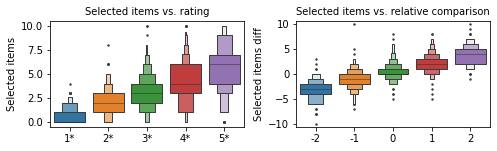

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, (ax, ax2) = plt.subplots(1,2,figsize=(7,2.2))
#f = plt.figure()
#f.set_figwidth(3.7)
#f.set_figheight(1.9)

sns.boxenplot(data = [gbr.loc[gbr.rating == 1, "selectedCount"],
              gbr.loc[gbr.rating == 2, "selectedCount"],
              gbr.loc[gbr.rating == 3, "selectedCount"],
              gbr.loc[gbr.rating == 4, "selectedCount"],
              gbr.loc[gbr.rating == 5, "selectedCount"]], linewidth=1, flier_kws={"marker":"o", "s":2}, ax=ax)
ax.set_ylim([-0.5, 10.5])
ax.set_xticklabels(["1*","2*","3*","4*","5*"])
ax.set_ylabel("Selected items")
ax.set_title("Selected items vs. rating", fontsize=10)

sns.boxenplot(data = [rcd.loc[rcd.relative_comparison_numeric == 2, "difference"],
              rcd.loc[rcd.relative_comparison_numeric == 1, "difference"],
              rcd.loc[rcd.relative_comparison_numeric == 0, "difference"],
              rcd.loc[rcd.relative_comparison_numeric == -1, "difference"],
              rcd.loc[rcd.relative_comparison_numeric == -2, "difference"]], 
              linewidth=1, flier_kws={"marker":"o", "s":2}, ax=ax2)
ax2.set_ylim([-10.5, 10.5])
ax2.set_xticklabels(["-2","-1","0","1","2"])
ax2.set_ylabel("Selected items diff")
ax2.set_title("Selected items vs. relative comparison", fontsize=10)

plt.tight_layout()
plt.savefig("low_high_comparison.pdf")
plt.show()